In [1]:
import json
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from pathlib import Path
import requests
import scipy.stats as st
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy import create_engine, inspect, text
from sqlalchemy.orm import Session

In [2]:
username = "postgres"
password = "postgres"
host = "localhost"
port = "5432"
database = "MSUDA-project-ETL-crowdfunding"

connection_string = f"postgresql://{username}:{password}@{host}:{port}/{database}"

In [3]:
engine = create_engine(connection_string)

In [4]:
try:
    with engine.connect() as test_connection:
        print(f"Connected! {test_connection}")
except Exception as e:
    print(f"Error: {e}")

Connected! <sqlalchemy.engine.base.Connection object at 0x122cf0450>


In [5]:
query = "SELECT * FROM campaign;"
campaign_df = pd.read_sql(query, engine)

campaign_df.head()

,cf_id,contact_id,company_name,description,goal,pledged,outcome,backers_count,country,currency,launch_date,end_date,category_id,subcategory_id,last_updated
0,147,4661,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,CAD,2020-02-13,2021-03-01,category1,subcategory1,2025-01-21 19:55:20.375810
1,1621,3765,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,USD,2021-01-25,2021-05-25,category2,subcategory2,2025-01-21 19:55:20.375810
2,1812,4187,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,AUD,2020-12-17,2021-12-30,category3,subcategory3,2025-01-21 19:55:20.375810
3,2156,4941,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,USD,2021-10-21,2022-01-17,category2,subcategory2,2025-01-21 19:55:20.375810
4,1365,2199,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,USD,2020-12-21,2021-08-23,category4,subcategory4,2025-01-21 19:55:20.375810


In [6]:
query = "SELECT * FROM contacts;"
contacts_df = pd.read_sql(query, engine)

contacts_df.head()

,contact_id,first_name,last_name,email,last_updated
0,4661,cecilia,velasco,cecilia.velasco@rodrigues.fr,2025-01-21 19:55:05.606676
1,3765,mariana,ellis,mariana.ellis@rossi.org,2025-01-21 19:55:05.606676
2,4187,sofie,woods,sofie.woods@riviere.com,2025-01-21 19:55:05.606676
3,4941,jeanette,iannotti,jeanette.iannotti@yahoo.com,2025-01-21 19:55:05.606676
4,2199,samuel,sorgatz,samuel.sorgatz@gmail.com,2025-01-21 19:55:05.606676


In [7]:
# Query the campaign and category tables for merge

df_table1 = pd.read_sql("SELECT * FROM campaign;", engine)
df_table2 = pd.read_sql("SELECT category_id, category FROM category;", engine)

# Merge campaign and category tables into dataframe and drop unnsessary columns

df_merged = pd.merge(df_table1, df_table2, on="category_id", suffixes=("", "_new"))
df_merged["category_id"] = df_merged["category"]
df_merged.drop(columns=["category_id", "subcategory_id", "cf_id", "contact_id", "launch_date", "end_date", "last_updated", "currency"], inplace=True)
df_merged.info()
df_merged.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   company_name   1000 non-null   object 
 1   description    1000 non-null   object 
 2   goal           1000 non-null   float64
 3   pledged        1000 non-null   float64
 4   outcome        1000 non-null   object 
 5   backers_count  1000 non-null   int64  
 6   country        1000 non-null   object 
 7   category       1000 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 62.6+ KB


,company_name,description,goal,pledged,outcome,backers_count,country,category
0,"Baldwin, Riley and Jackson",Pre-emptive tertiary standardization,100.0,0.0,failed,0,CA,food
1,Odom Inc,Managed bottom-line architecture,1400.0,14560.0,successful,158,US,music
2,"Melton, Robinson and Fritz",Function-based leadingedge pricing structure,108400.0,142523.0,successful,1425,AU,technology
3,"Mcdonald, Gonzalez and Ross",Vision-oriented fresh-thinking conglomeration,4200.0,2477.0,failed,24,US,music
4,Larson-Little,Proactive foreground core,7600.0,5265.0,failed,53,US,theater


In [8]:
# Query 1 all succesful campaigns by country

query = "SELECT company_name, description, backers_count, pledged, outcome, country FROM campaign WHERE outcome = 'successful' ORDER BY backers_count DESC;"

query1_df = pd.read_sql(query, engine)
query1_df.head()

,company_name,description,backers_count,pledged,outcome,country
0,Fox-Williams,Profound system-worthy functionalities,7295,196960.0,successful,US
1,Avila-Nelson,Up-sized intermediate website,6465,168095.0,successful,US
2,"Hughes, Mendez and Patterson",Stand-alone multi-state data-warehouse,6406,179356.0,successful,US
3,Padilla-Porter,Innovative exuding matrix,6286,182302.0,successful,US
4,Schmitt-Mendoza,Profound explicit paradigm,6212,167717.0,successful,US


In [9]:
# Query 2 all failed campaign by country

query = "SELECT cf_id, company_name, description, backers_count, pledged, outcome, country FROM campaign WHERE outcome = 'failed' ORDER BY backers_count DESC;"

query2_df = pd.read_sql(query, engine)
query2_df.head()

,cf_id,company_name,description,backers_count,pledged,outcome,country
0,1281,Rosario-Smith,Enterprise-wide intermediate portal,6080,188480.0,failed,CA
1,2171,"Whitehead, Bell and Hughes",Multi-tiered radical definition,5681,176112.0,failed,US
2,2201,Davis and Sons,Innovative human-resource migration,5497,159405.0,failed,US
3,507,"Ferguson, Murphy and Bright",Multi-lateral heuristic throughput,4697,178483.0,failed,US
4,2837,Kelly-Colon,Stand-alone grid-enabled leverage,4428,110689.0,failed,AU


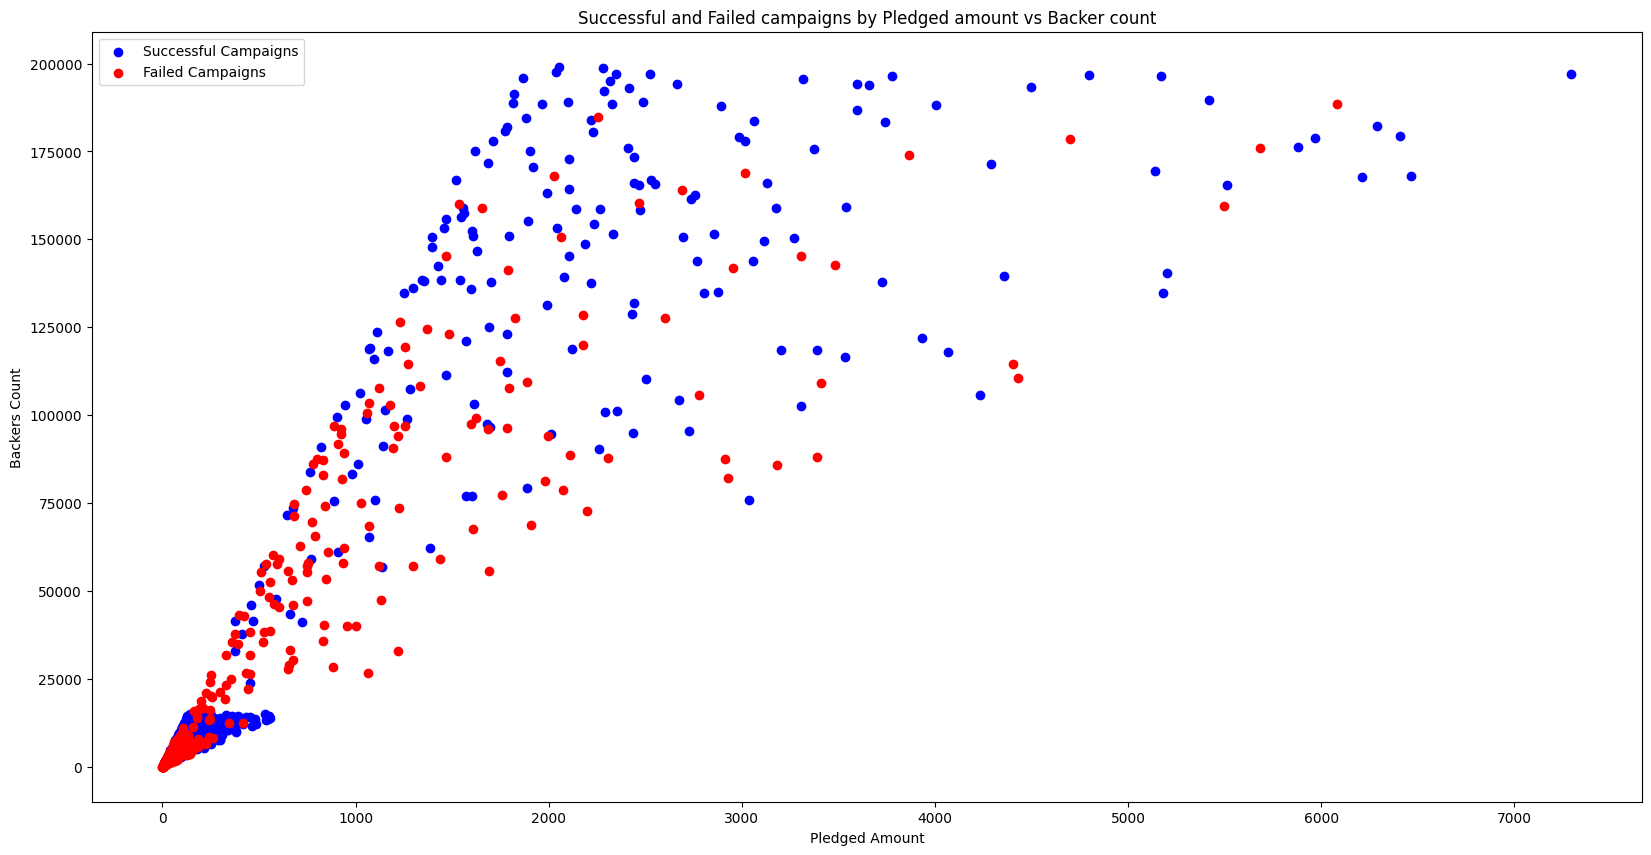

In [10]:
# Scatter plot of both success and failed Data frames by number of backer vs pledged amounts
plt.figure(figsize=(20, 10))
plt.scatter(query1_df['backers_count'], query1_df['pledged'], color='blue', label='Successful Campaigns')
plt.scatter(query2_df['backers_count'], query2_df['pledged'], color='red', label='Failed Campaigns')

# Add labels and legend
plt.xlabel('Pledged Amount')
plt.ylabel('Backers Count')
plt.title('Successful and Failed campaigns by Pledged amount vs Backer count')
plt.legend()

# Show the plot
plt.savefig("resources/output/figs/fig1.png")
plt.show()

In [11]:
# Query 3

query = "SELECT description, pledged, outcome, country FROM campaign WHERE outcome = 'successful' ORDER BY country DESC"

query3_df = pd.read_sql(query, engine)
query3_df

,description,pledged,outcome,country
0,Vision-oriented scalable definition,153216.0,successful,US
1,Reduced next generation info-mediaries,6358.0,successful,US
2,Programmable leadingedge contingency,14725.0,successful,US
3,Multi-layered global groupware,11174.0,successful,US
4,Switchable methodical superstructure,182036.0,successful,US
...,...,...,...,...
560,Digitized local info-mediaries,77012.0,successful,AU
561,Optional tangible pricing structure,5107.0,successful,AU
562,Customer-focused client-server service-desk,193413.0,successful,AU
563,Exclusive fresh-thinking model,13250.0,successful,AU


In [12]:
# Query 4

query = "SELECT cf_id, company_name, description, backers_count, pledged, outcome FROM campaign WHERE outcome = 'successful' ORDER BY backers_count DESC;"

query4_df = pd.read_sql(query, engine)
query4_df.head()

,cf_id,company_name,description,backers_count,pledged,outcome
0,1659,Fox-Williams,Profound system-worthy functionalities,7295,196960.0,successful
1,211,Avila-Nelson,Up-sized intermediate website,6465,168095.0,successful
2,1875,"Hughes, Mendez and Patterson",Stand-alone multi-state data-warehouse,6406,179356.0,successful
3,305,Padilla-Porter,Innovative exuding matrix,6286,182302.0,successful
4,2301,Schmitt-Mendoza,Profound explicit paradigm,6212,167717.0,successful


In [13]:
# Query 5 successful campaigns by country

query = "SELECT country, COUNT(*) AS successful_campaigns FROM campaign WHERE outcome = 'successful' GROUP BY country ORDER BY successful_campaigns DESC;"
query5_df = pd.read_sql(query, engine)
query5_df

,country,successful_campaigns
0,US,436
1,GB,28
2,IT,26
3,AU,24
4,CA,22
5,DK,17
6,CH,12


In [14]:
# Convert successful campaigns by country to percentage and plot as donut chart

query5_df["Percentage"] = (query5_df["successful_campaigns"] / query5_df["successful_campaigns"].sum()) * 100
query5_df

,country,successful_campaigns,Percentage
0,US,436,77.168142
1,GB,28,4.955752
2,IT,26,4.601770
3,AU,24,4.247788
4,CA,22,3.893805
5,DK,17,3.008850
6,CH,12,2.123894


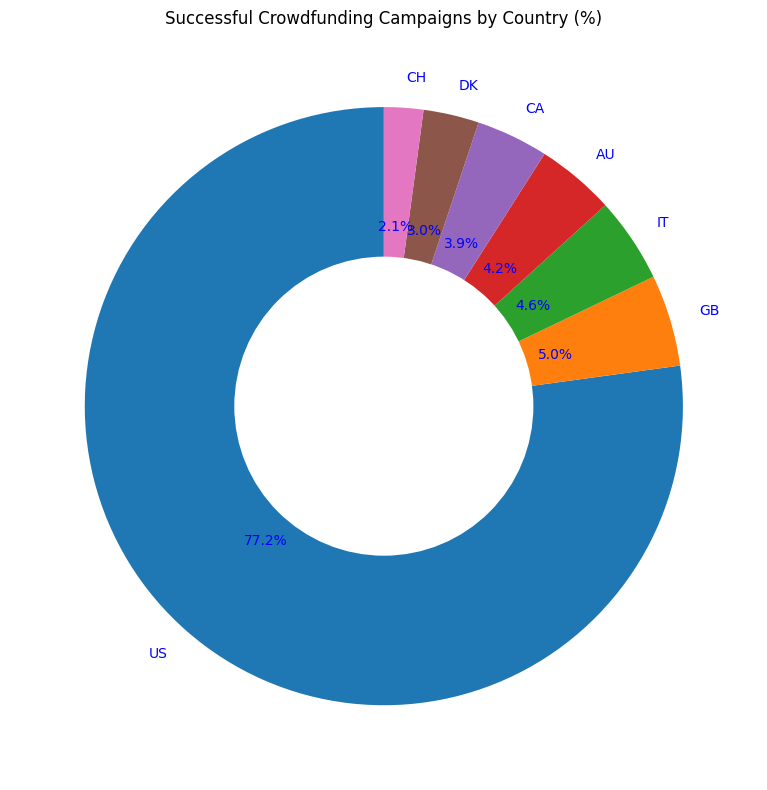

In [15]:
# Create donut chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    query5_df["Percentage"], 
    labels = query5_df["country"],
    autopct = "%.1f%%", 
    startangle = 90, 
    textprops = dict(color="b")
)

# Draw a circle at the center to create a donut shape
center_circle = plt.Circle((0, 0), 0.50, fc='white')
fig.gca().add_artist(center_circle)

# Customize plot
ax.set_title("Successful Crowdfunding Campaigns by Country (%)")
plt.tight_layout()
plt.savefig("resources/output/figs/fig2.png")
plt.show()


In [16]:
# Query 6 failed campaigns by country

query = "SELECT country, COUNT(*) AS failed_campaigns FROM campaign WHERE outcome = 'failed' GROUP BY country ORDER BY failed_campaigns DESC;"

query6_df = pd.read_sql(query, engine)
query6_df.head()

,country,failed_campaigns
0,US,274
1,CA,19
2,IT,19
3,GB,18
4,AU,16


In [17]:
# Convert failed campaigns by country to percentage and plot as donut chart

query6_df["Percentage"] = (query6_df["failed_campaigns"] / query6_df["failed_campaigns"].sum()) * 100
query6_df

,country,failed_campaigns,Percentage
0,US,274,75.274725
1,CA,19,5.219780
2,IT,19,5.219780
3,GB,18,4.945055
4,AU,16,4.395604
5,DK,12,3.296703
6,CH,6,1.648352


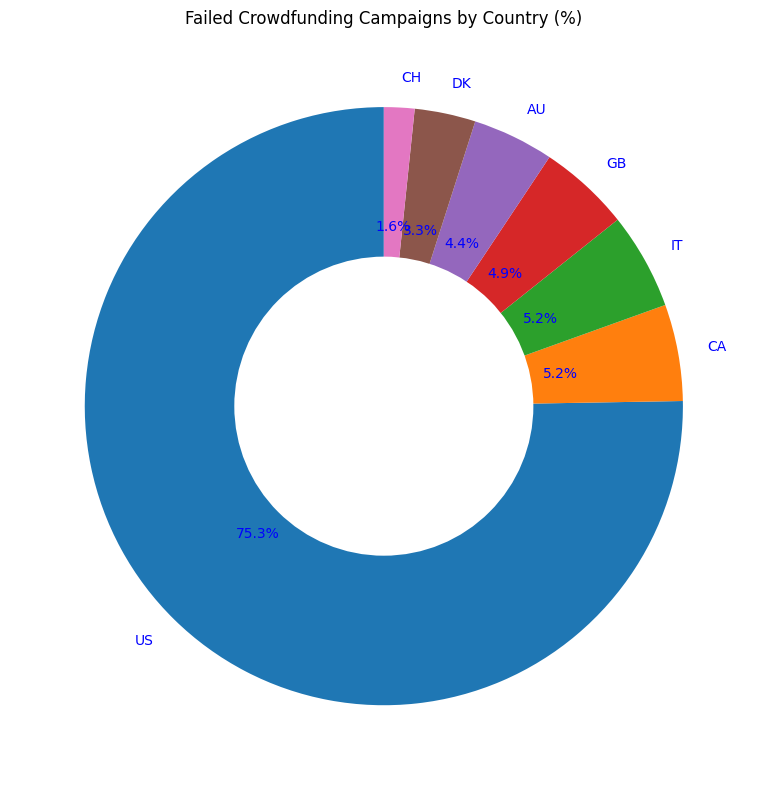

In [18]:
# Create donut chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    query6_df["Percentage"], 
    labels = query6_df["country"],
    autopct = "%.1f%%", 
    startangle = 90, 
    textprops = dict(color="b")
)

# Draw a circle at the center to create a donut shape
center_circle = plt.Circle((0, 0), 0.50, fc='white')
fig.gca().add_artist(center_circle)

# Customize plot
ax.set_title("Failed Crowdfunding Campaigns by Country (%)")
plt.tight_layout()
plt.savefig("resources/output/figs/fig3.png")
plt.show()


In [19]:
# Filter for successful campaigns
successful_campaigns = df_merged[df_merged["outcome"] == "successful"]

# Group by category and count successful campaigns
category_counts = successful_campaigns.groupby("category")["description"].count()

# Rename Column
category_counts.name = "successful campaigns"

# Sort categories by the count of successful campaigns
successful_category = category_counts.sort_values(ascending=False)

# Convert to DF
success_df = pd.DataFrame(successful_category).reset_index()

# Display the results
success_df.info()
success_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   category              9 non-null      object
 1   successful campaigns  9 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 276.0+ bytes


,category,successful campaigns
0,theater,187
1,film & video,102
2,music,99
3,technology,64
4,publishing,40
5,photography,26
6,food,22
7,games,21
8,journalism,4


In [20]:
# Filter for failed campaigns
failed_campaigns = df_merged[df_merged["outcome"] == "failed"]

# Group by category and count successful campaigns
category_counts = failed_campaigns.groupby("category")["description"].count()

# Rename Column
category_counts.name = "failed campaigns"

# Sort categories by the count of successful campaigns
failed_category = category_counts.sort_values(ascending=False)

# Convert to DF
failed_df = pd.DataFrame(failed_category).reset_index()

# Display the results
failed_df.info()
failed_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   category          8 non-null      object
 1   failed campaigns  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 260.0+ bytes


,category,failed campaigns
0,theater,132
1,music,66
2,film & video,60
3,technology,28
4,publishing,24
5,games,23
6,food,20
7,photography,11


In [21]:
# Create one Data Frame with both successful and failed category counts
result_df = pd.merge(failed_df, success_df, on='category', how='outer').fillna(0)
result_df

,category,failed campaigns,successful campaigns
0,film & video,60.0,102
1,food,20.0,22
2,games,23.0,21
3,journalism,0.0,4
4,music,66.0,99
5,photography,11.0,26
6,publishing,24.0,40
7,technology,28.0,64
8,theater,132.0,187


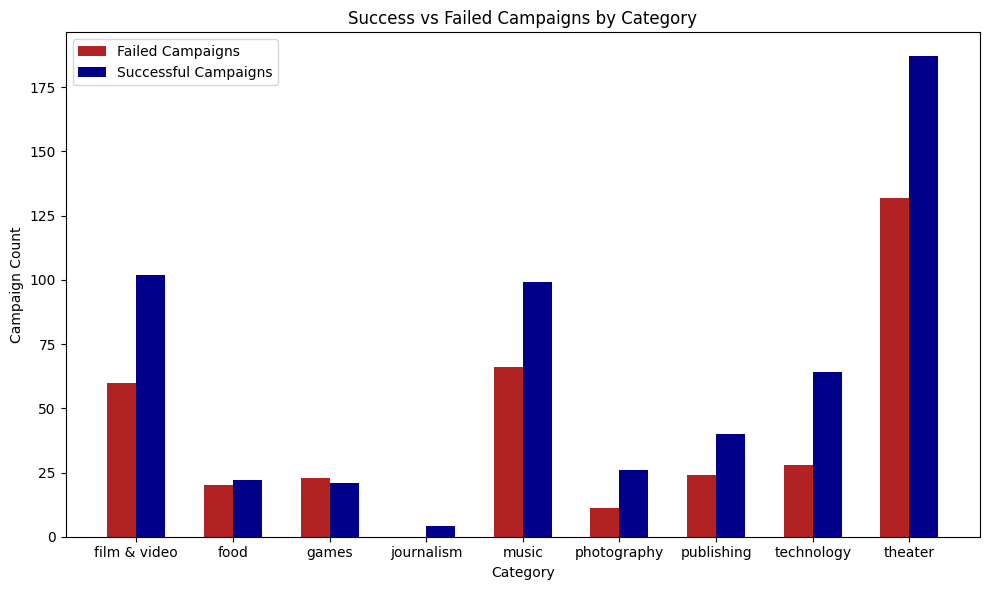

In [22]:
# Nested Bar chart
plt.figure(figsize=(10, 6))
bar_width = 0.3
x = range(len(result_df['category']))  # Base positions for the bars

# Create the bar chart
plt.bar(x, result_df['failed campaigns'], width=bar_width, label='Failed Campaigns', color='firebrick')
plt.bar([pos + bar_width for pos in x], result_df['successful campaigns'], width=bar_width, label='Successful Campaigns', color='darkblue')

# Customize the chart
plt.xlabel('Category')
plt.ylabel('Campaign Count')
plt.title('Success vs Failed Campaigns by Category')
plt.xticks([pos + bar_width / 2 for pos in x], result_df['category'])  # Center the category labels
plt.legend()

# Show the plot
plt.tight_layout()
plt.savefig("resources/output/figs/fig4.png")
plt.show()